[Source](https://www.tensorflow.org/tutorials/keras/regression)

In [1]:
pip install -q seaborn

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.5.0


In [4]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [5]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [6]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

[isna()](https://towardsdatascience.com/handling-missing-values-with-pandas-b876bf6f008f)

In [7]:
dataset = dataset.dropna()

In [8]:
dataset['Origin'] = dataset['Origin'].map({1:'USA', 2:'Europe', 3:'Japan'})

In [9]:
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


[pandas.get_dummies](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html)

In [10]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

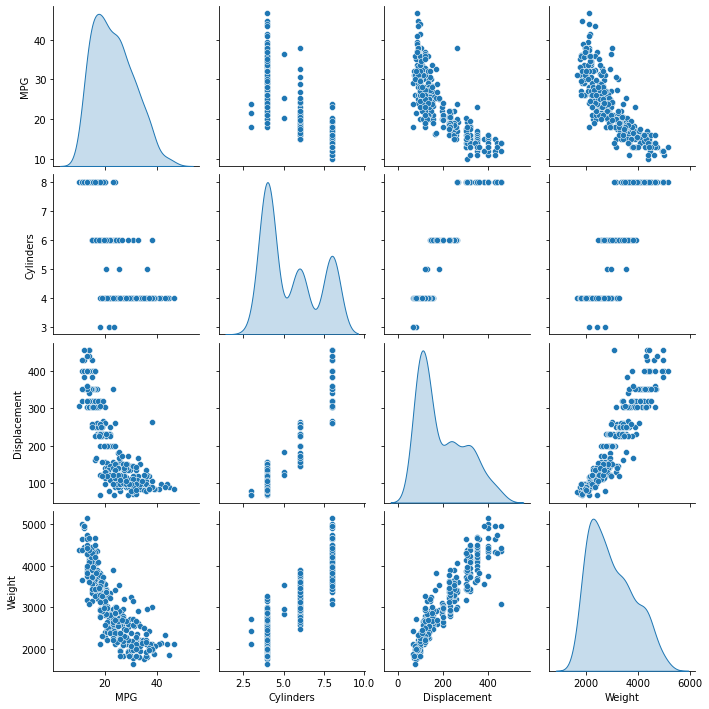

In [11]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind = 'kde')

In [12]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


[seaborn.pairplot](https://seaborn.pydata.org/generated/seaborn.pairplot.html)

In [13]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

In [14]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Europe,0.178344,0.383413
Japan,0.197452,0.398712
USA,0.624204,0.485101


In [15]:
normalizer = preprocessing.Normalization(axis=-1)

[preprocessing.Noramlization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Normalization)

In [16]:
normalizer.adapt(np.array(train_features))

In [17]:
print(normalizer.mean.numpy())

[   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
    0.624]


In [18]:
train_features

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
146,4,90.0,75.0,2125.0,14.5,74,0,0,1
282,4,140.0,88.0,2890.0,17.3,79,0,0,1
69,8,350.0,160.0,4456.0,13.5,72,0,0,1
378,4,105.0,63.0,2125.0,14.7,82,0,0,1
331,4,97.0,67.0,2145.0,18.0,80,0,1,0
...,...,...,...,...,...,...,...,...,...
281,6,200.0,85.0,2990.0,18.2,79,0,0,1
229,8,400.0,180.0,4220.0,11.1,77,0,0,1
150,4,108.0,93.0,2391.0,15.5,74,0,1,0
145,4,83.0,61.0,2003.0,19.0,74,0,1,0


DNN model

In [19]:
horsepower = np.array(train_features['Horsepower'])
horsepower_normalizer = preprocessing.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)

In [20]:
horsepower_model = tf.keras.Sequential([
  horsepower_normalizer,
  layers.Dense(units=1)                                        
])
horsepower_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [21]:
horsepower_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss="mean_absolute_error"
)

In [22]:
%%time
history = horsepower_model.fit(train_features['Horsepower'], train_labels, epochs=100,  verbose = 0, validation_split=0.2)

CPU times: user 2.93 s, sys: 130 ms, total: 3.06 s
Wall time: 2.88 s


In [23]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

In [24]:
hist.tail()

,loss,val_loss,epoch
95,3.803835,4.180460,95
96,3.805197,4.203748,96
97,3.804189,4.190164,97
98,3.802636,4.187232,98
99,3.802990,4.193316,99


In [25]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0,10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

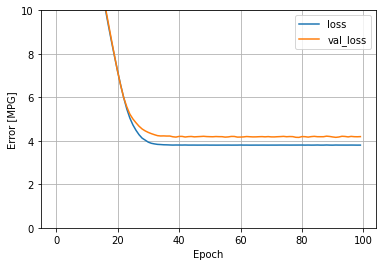

In [26]:
plot_loss(history)

In [27]:
test_result = {}
test_result['horsepower_model'] = horsepower_model.evaluate(test_features['Horsepower'], test_labels, verbose =0)

In [28]:
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

[tf.linspace](https://numpy.org/doc/stable/reference/generated/numpy.linspace.html)

In [29]:
def plot_horsepower(x, y):
  plt.scatter(train_features['Horsepower'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

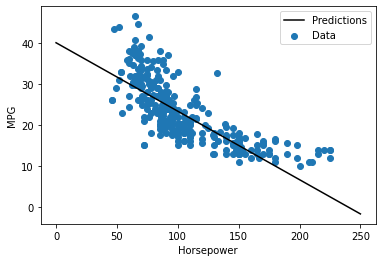

In [30]:
plot_horsepower(x, y)

In [31]:
linear_model = tf.keras.Sequential([
  normalizer, 
  layers.Dense(units=1)                                    
])

In [32]:
linear_model.predict(train_features[:10])

array([[-0.204],
       [-1.011],
       [ 0.795],
       [-0.851],
       [ 0.555],
       [-0.683],
       [ 0.385],
       [-2.266],
       [-0.274],
       [ 0.92 ]], dtype=float32)

In [33]:
linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[ 0.123],
       [ 0.062],
       [-0.013],
       [ 0.088],
       [-0.52 ],
       [-0.286],
       [-0.548],
       [ 0.328],
       [-0.507]], dtype=float32)>

In [34]:
linear_model.compile(
    optimizer = tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error'
)

In [35]:
%%time
history = linear_model.fit(train_features, train_labels, epochs=100, verbose=0, validation_split=0.2)

CPU times: user 2.88 s, sys: 142 ms, total: 3.02 s
Wall time: 2.92 s


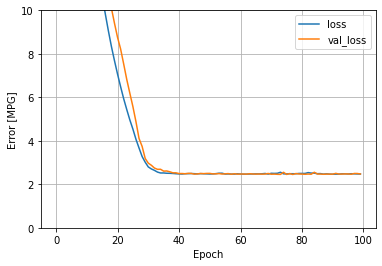

In [36]:
plot_loss(history)

In [37]:
test_result['linear_model'] = linear_model.evaluate(test_features, test_labels, verbose=0)

In [38]:
def build_and_compile_model(norm):
  model = keras.Sequential([
    norm, 
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(1)                           
  ])
  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [39]:
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

In [40]:
dnn_horsepower_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [41]:
%%time
history = dnn_horsepower_model.fit(train_features['Horsepower'], train_labels, validation_split=0.2, verbose = 0, epochs = 100)

CPU times: user 3.32 s, sys: 162 ms, total: 3.48 s
Wall time: 3.21 s


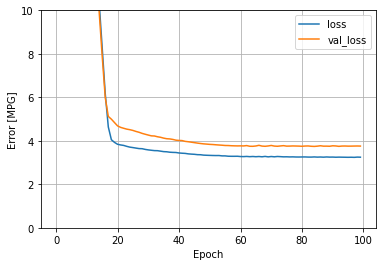

In [42]:
plot_loss(history)

In [43]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model(x)

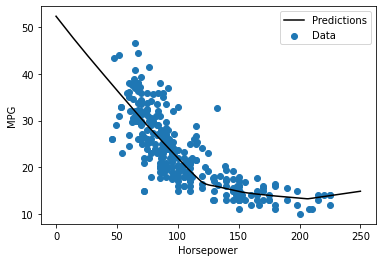

In [44]:
plot_horsepower(x, y)

In [45]:
test_result['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(test_features['Horsepower'], test_labels, verbose = 0)

In [46]:
pd.DataFrame(test_result, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.651658
linear_model,2.489586
dnn_horsepower_model,2.894846


In [47]:
dnn_model = build_and_compile_model(normalizer)
history = dnn_model.fit(train_features, train_labels,validation_split=0.2,verbose=0, epochs=100)

In [48]:
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 9)                 19        
_________________________________________________________________
dense_5 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


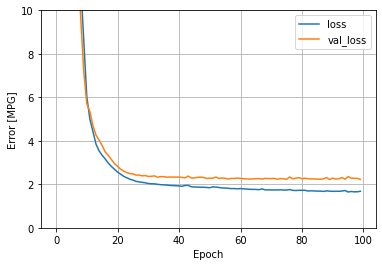

In [49]:
plot_loss(history)

In [50]:
test_result['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose = 0)

In [51]:
pd.DataFrame(test_result, index=['Mean absolute error MPG']).T

,Mean absolute error MPG
horsepower_model,3.651658
linear_model,2.489586
dnn_horsepower_model,2.894846
dnn_model,1.734194


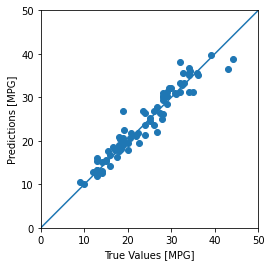

In [52]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

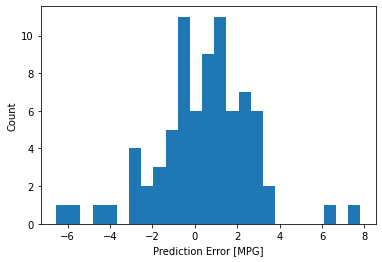

In [53]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')